# Pricing Orchestration

Runs cds_pricing.ipynb across copula types, then compiles results and produces comparison charts.

In [2]:
import papermill as pm
import scrapbook as sb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

## 1. Configuration

In [3]:
# Notebook to run
PRICING_NOTEBOOK = 'cds_pricing.ipynb'

# Output directory for executed notebooks
OUTPUT_DIR = Path('output/runs/pricing')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Report output directories
FIGS_DIR = Path('output/figs_for_report')
TABLES_DIR = Path('output/tables_for_report')
FIGS_DIR.mkdir(parents=True, exist_ok=True)
TABLES_DIR.mkdir(parents=True, exist_ok=True)

# Fixed parameters
FIXED_PARAMS = {
    'DATA_MODE': 'real',
    'SPREAD_MEASURE': 'delta',
    'K': 5,
    'RNG_METHOD': 'sobol',
    'N_SIMS': 100_000,
    'FIG_OUTPUT_DIR': 'figs_for_report',
}

TERM = 5.0  # Contract term in years

# Parameters to vary
COPULAS = ['gaussian', 't']
CORR_LEVELS = ['high'] 

print(f"Fixed parameters: {FIXED_PARAMS}")
print(f"Copulas: {COPULAS}")
print(f"Correlation levels: {CORR_LEVELS}")

Fixed parameters: {'DATA_MODE': 'real', 'SPREAD_MEASURE': 'delta', 'K': 5, 'RNG_METHOD': 'sobol', 'N_SIMS': 100000, 'FIG_OUTPUT_DIR': 'figs_for_report'}
Copulas: ['gaussian', 't']
Correlation levels: ['high']


## 2. Execute Pricing Runs

In [4]:
executed_notebooks = []

for corr_level in CORR_LEVELS:
    for copula in COPULAS:
        # Build parameter set
        params = {
            **FIXED_PARAMS,
            'COPULA': copula,
            'CORR_LEVEL': corr_level,
        }
        
        # Output notebook path
        output_path = OUTPUT_DIR / f'pricing_{corr_level}_{copula}.ipynb'
        
        print(f"\n{'='*60}")
        print(f"Running: CORR_LEVEL={corr_level}, COPULA={copula}")
        print(f"Output: {output_path}")
        print(f"{'='*60}")
        
        try:
            pm.execute_notebook(
                PRICING_NOTEBOOK,
                output_path,
                parameters=params,
                kernel_name='python3'
            )
            executed_notebooks.append(output_path)
            print(f"Completed successfully")
        except Exception as e:
            print(f"Failed: {e}")

print(f"\n\nExecuted {len(executed_notebooks)} notebooks")


Running: CORR_LEVEL=high, COPULA=gaussian
Output: output\runs\pricing\pricing_high_gaussian.ipynb


Executing:   0%|          | 0/43 [00:00<?, ?cell/s]

Completed successfully

Running: CORR_LEVEL=high, COPULA=t
Output: output\runs\pricing\pricing_high_t.ipynb


Executing:   0%|          | 0/43 [00:00<?, ?cell/s]

Completed successfully


Executed 2 notebooks


## 3. Collect Results

In [5]:
# Read glued values from executed notebooks
results = []
default_times = {}

for nb_path in executed_notebooks:
    nb = sb.read_notebook(str(nb_path))
    scraps = nb.scraps
    
    # Extract parameters from filename
    parts = nb_path.stem.split('_')  # pricing_concentrated_gaussian
    corr_level = parts[1]
    copula = parts[2]
    
    # Collect summary results
    results.append({
        'corr_level': corr_level,
        'copula': copula,
        'K': scraps['K'].data,
        'fair_spread_bps': scraps['fair_spread'].data,
        'se_bps': scraps['se_bps'].data,
        'n_defaults_in_term': scraps['n_defaults_in_term'].data if 'n_defaults_in_term' in scraps else None,
        'rng_method': scraps['RNG_METHOD'].data,
        'n_sims': scraps['N_SIMS'].data,
    })
    
    # Collect default times array for comparison charts
    if 'kth_default_times' in scraps:
        default_times[copula] = np.array(scraps['kth_default_times'].data, dtype=float)
        print(f"Loaded {len(default_times[copula]):,} default times for {copula} copula")

results_df = pd.DataFrame(results)
print("\nPricing Results:")
display(results_df)

Loaded 100,000 default times for gaussian copula
Loaded 100,000 default times for t copula

Pricing Results:


,corr_level,copula,K,fair_spread_bps,se_bps,n_defaults_in_term,rng_method,n_sims
0,high,gaussian,5,7.359385,0.297195,612,sobol,100000
1,high,t,5,53.842125,0.812736,4388,sobol,100000


## 4. Summary Table

In [6]:
# Save results
results_df.to_csv(TABLES_DIR / 'pricing_results.csv', index=False)
print(f"Results saved to {TABLES_DIR / 'pricing_results.csv'}")

# Format for markdown
print("\nMarkdown table for report:")
print("")
print("| Copula | Fair Spread (bps) | SE (bps) | 95% CI |")
print("|--------|------------------:|---------:|-------:|")

for _, row in results_df.iterrows():
    copula_name = 'Gaussian' if row['copula'] == 'gaussian' else 'Student-t'
    ci_lower = row['fair_spread_bps'] - 1.96 * row['se_bps']
    ci_upper = row['fair_spread_bps'] + 1.96 * row['se_bps']
    print(f"| {copula_name} | {row['fair_spread_bps']:.2f} | {row['se_bps']:.2f} | [{ci_lower:.2f}, {ci_upper:.2f}] |")

Results saved to output\tables_for_report\pricing_results.csv

Markdown table for report:

| Copula | Fair Spread (bps) | SE (bps) | 95% CI |
|--------|------------------:|---------:|-------:|
| Gaussian | 7.36 | 0.30 | [6.78, 7.94] |
| Student-t | 53.84 | 0.81 | [52.25, 55.44] |


## 5. Comparison Charts

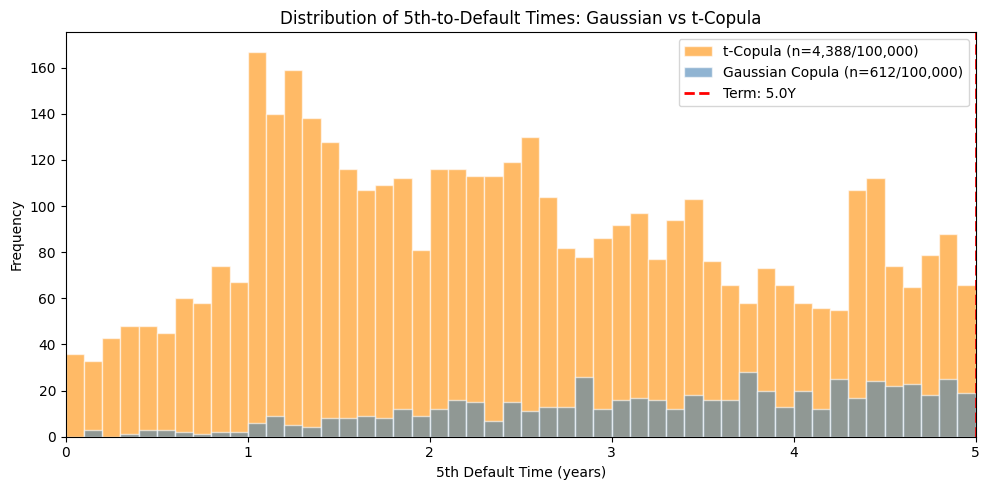

In [7]:
# Chart 1: Overlapping histograms of default time distributions
if len(default_times) == 2:
    fig, ax = plt.subplots(figsize=(10, 5))
    
    colors = {'gaussian': 'steelblue', 't': 'darkorange'}
    labels = {'gaussian': 'Gaussian Copula', 't': 't-Copula'}
    
    max_time = TERM
    
    # Define shared bins
    bins = np.linspace(0, max_time, 51)
    
    # Plot t-copula FIRST (so it's behind)
    for copula in ['t', 'gaussian']:
        times = default_times[copula]
        n_total = len(times)
        finite_times = times[(times < np.inf) & (times <= max_time)]
        n_in_term = len(finite_times)
        
        ax.hist(
            finite_times, 
            bins=bins,
            alpha=0.6, 
            label=f"{labels[copula]} (n={n_in_term:,}/{n_total:,})",
            color=colors[copula],
            edgecolor='white'
        )
    
    ax.axvline(TERM, color='red', linestyle='--', linewidth=2, label=f'Term: {TERM}Y')
    ax.set_xlabel('5th Default Time (years)')
    ax.set_ylabel('Frequency')
    ax.set_title('Distribution of 5th-to-Default Times: Gaussian vs t-Copula')
    ax.legend()
    ax.set_xlim(0, max_time)
    plt.tight_layout()
    plt.savefig(FIGS_DIR / 'default_time_comparison.png', dpi=150)
    plt.show()

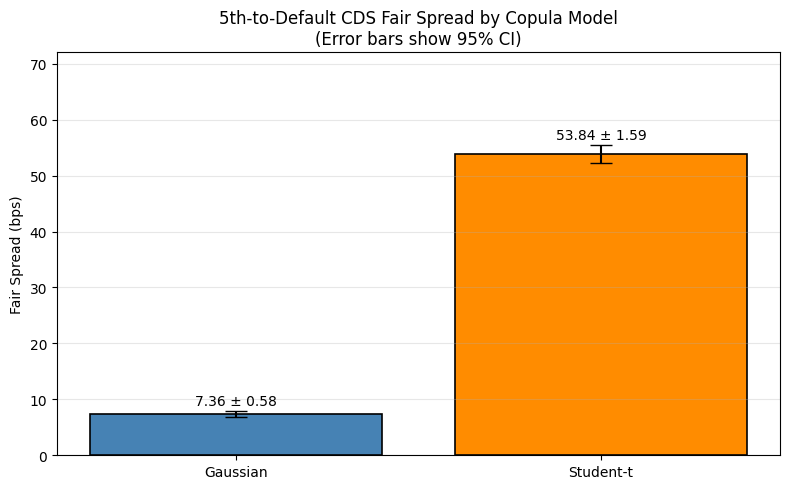

In [8]:
# Chart 2: Fair spread comparison with error bars
fig, ax = plt.subplots(figsize=(8, 5))

copula_names = ['Gaussian', 'Student-t']
spreads = results_df['fair_spread_bps'].values
errors = 1.96 * results_df['se_bps'].values  # 95% CI

x_pos = np.arange(len(copula_names))
bars = ax.bar(x_pos, spreads, yerr=errors, capsize=8, 
              color=['steelblue', 'darkorange'], edgecolor='black', linewidth=1.2)

# Add value labels on bars
for i, (bar, spread, se) in enumerate(zip(bars, spreads, results_df['se_bps'].values)):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + errors[i] + 0.5,
            f'{spread:.2f} ± {1.96*se:.2f}', ha='center', va='bottom', fontsize=10)

ax.set_xticks(x_pos)
ax.set_xticklabels(copula_names)
ax.set_ylabel('Fair Spread (bps)')
ax.set_title('5th-to-Default CDS Fair Spread by Copula Model\n(Error bars show 95% CI)')
ax.set_ylim(0, max(spreads + errors) * 1.3)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(FIGS_DIR / 'spread_comparison.png', dpi=150)
plt.show()

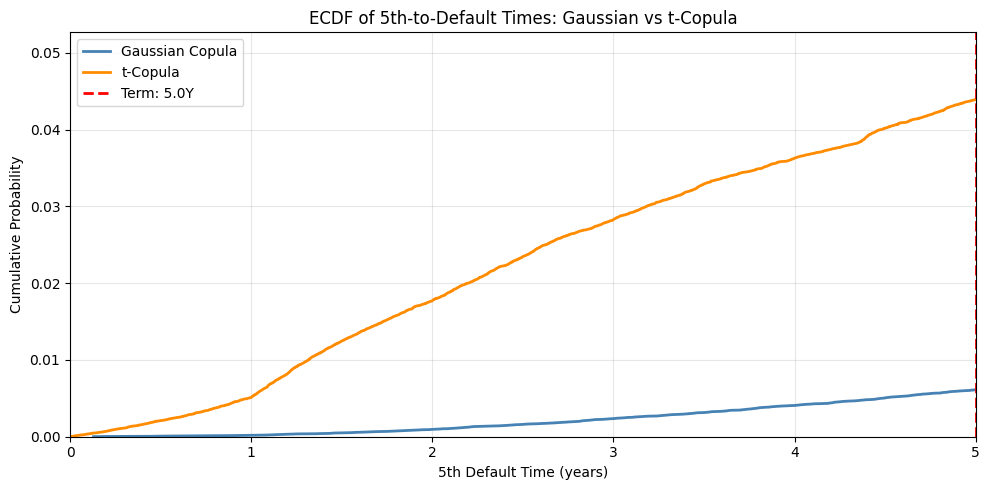

In [9]:
# Chart 3: ECDF comparison - zoom into relevant probability range
if len(default_times) == 2:
    fig, ax = plt.subplots(figsize=(10, 5))
    
    colors = {'gaussian': 'steelblue', 't': 'darkorange'}
    labels = {'gaussian': 'Gaussian Copula', 't': 't-Copula'}
    
    for copula in COPULAS:
        times = default_times[copula]
        # Only plot finite default times
        finite_times = times[times < np.inf]
        if len(finite_times) > 0:
            sorted_times = np.sort(finite_times)
            # ECDF as fraction of total simulations (not just finite)
            ecdf = np.arange(1, len(sorted_times) + 1) / len(times)
            ax.plot(sorted_times, ecdf, label=labels[copula], color=colors[copula], linewidth=2)
    
    ax.axvline(TERM, color='red', linestyle='--', linewidth=2, label=f'Term: {TERM}Y')
    ax.set_xlabel('5th Default Time (years)')
    ax.set_ylabel('Cumulative Probability')
    ax.set_title('ECDF of 5th-to-Default Times: Gaussian vs t-Copula')
    ax.legend()
    ax.set_xlim(0, TERM)
    # Zoom Y-axis to relevant range
    max_prob = max((default_times[c] < np.inf).mean() for c in COPULAS)
    ax.set_ylim(0, max_prob * 1.2)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(FIGS_DIR / 'default_time_ecdf_comparison.png', dpi=150)
    plt.show()

## 6. Summary

In [10]:
print("="*60)
print("PRICING COMPARISON SUMMARY")
print("="*60)
print(f"\nBasket: 5th-to-default on 5 financial sector names")
print(f"Term: {TERM} years")
print(f"Simulations: {FIXED_PARAMS['N_SIMS']:,}")
print(f"RNG Method: {FIXED_PARAMS['RNG_METHOD']}")
print("\nResults:")
for _, row in results_df.iterrows():
    copula_name = 'Gaussian' if row['copula'] == 'gaussian' else 't-Copula'
    print(f"  {copula_name}: {row['fair_spread_bps']:.2f} bps (SE: {row['se_bps']:.2f})")

# Spread ratio
if len(results_df) == 2:
    g_spread = results_df[results_df['copula'] == 'gaussian']['fair_spread_bps'].values[0]
    t_spread = results_df[results_df['copula'] == 't']['fair_spread_bps'].values[0]
    print(f"\nt-Copula spread is {t_spread/g_spread:.1f}x the Gaussian spread")
    print(f"Difference: {t_spread - g_spread:.2f} bps")

PRICING COMPARISON SUMMARY

Basket: 5th-to-default on 5 financial sector names
Term: 5.0 years
Simulations: 100,000
RNG Method: sobol

Results:
  Gaussian: 7.36 bps (SE: 0.30)
  t-Copula: 53.84 bps (SE: 0.81)

t-Copula spread is 7.3x the Gaussian spread
Difference: 46.48 bps
